# EEGMMIDB — Data Exploration & NeuroGPT Classification

Goal:
- Load the EEGMMIDB motor movement / imagery dataset
- Explore signals and labels
- Classification with NeuroGPT usage

In [1]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch

# Project paths
PROJECT_ROOT = Path.cwd()
SRC_PATH = PROJECT_ROOT / "src"
DATA_PATH = PROJECT_ROOT / "data" / "physionet.org" / "files" / "eegmmidb" / "1.0.0"

sys.path.append(str(SRC_PATH))

from dataloader import EEGMMIDBDataset

print("Project root:", PROJECT_ROOT)
print("Data path:", DATA_PATH)

Project root: /Users/simonkerner/Desktop/Github/neuro-eeg
Data path: /Users/simonkerner/Desktop/Github/neuro-eeg/data/physionet.org/files/eegmmidb/1.0.0


In [2]:
import mne

edf = DATA_PATH / "S001" / "S001R03.edf"
raw = mne.io.read_raw_edf(edf, preload=False, verbose=False)

print(sorted(raw.ch_names))


['Af3.', 'Af4.', 'Af7.', 'Af8.', 'Afz.', 'C1..', 'C2..', 'C3..', 'C4..', 'C5..', 'C6..', 'Cp1.', 'Cp2.', 'Cp3.', 'Cp4.', 'Cp5.', 'Cp6.', 'Cpz.', 'Cz..', 'F1..', 'F2..', 'F3..', 'F4..', 'F5..', 'F6..', 'F7..', 'F8..', 'Fc1.', 'Fc2.', 'Fc3.', 'Fc4.', 'Fc5.', 'Fc6.', 'Fcz.', 'Fp1.', 'Fp2.', 'Fpz.', 'Ft7.', 'Ft8.', 'Fz..', 'Iz..', 'O1..', 'O2..', 'Oz..', 'P1..', 'P2..', 'P3..', 'P4..', 'P5..', 'P6..', 'P7..', 'P8..', 'Po3.', 'Po4.', 'Po7.', 'Po8.', 'Poz.', 'Pz..', 'T10.', 'T7..', 'T8..', 'T9..', 'Tp7.', 'Tp8.']


## Load Dataset for exploration

Subject 1, motor execution + imagery, left/right hand

Classes:
- 0: Right imagined
- 1: Right real
- 2: Left imagined
- 3: Left real

In [3]:
dataset = EEGMMIDBDataset(
    root_path=str(DATA_PATH),
    subjects=[1],
    runs=[3, 4, 7, 8, 11, 12],
    t_min=0.0,
    t_max=2.0,
    normalization=True
)

print("Total extracted trials:", len(dataset))

Total extracted trials: 90


In [4]:
from collections import Counter

labels = [dataset[i]["labels"].item() for i in range(len(dataset))]

label_map = {
    0: "Right Imagined",
    1: "Right Real",
    2: "Left Imagined",
    3: "Left Real"
}

counts = Counter(labels)

print("Dataset-level class counts:")
for k in sorted(label_map):
    print(f"{label_map[k]:<15}: {counts.get(k, 0)}")


Dataset-level class counts:
Right Imagined : 22
Right Real     : 22
Left Imagined  : 23
Left Real      : 23


In [5]:
import mne
from collections import defaultdict

event_summary = defaultdict(lambda: defaultdict(int))

for run in [3, 4, 7, 8, 11, 12]:
    edf_path = DATA_PATH / "S001" / f"S001R{run:02d}.edf"
    raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
    
    _, event_id = mne.events_from_annotations(raw, verbose=False)
    
    for label in event_id.keys():
        event_code = label.split("/")[-1]
        event_summary[run][event_code] += 1

print("Raw EDF annotation summary (Subject 1):\n")
for run, events in event_summary.items():
    print(f"Run {run}: {dict(events)}")


Raw EDF annotation summary (Subject 1):

Run 3: {'T0': 1, 'T1': 1, 'T2': 1}
Run 4: {'T0': 1, 'T1': 1, 'T2': 1}
Run 7: {'T0': 1, 'T1': 1, 'T2': 1}
Run 8: {'T0': 1, 'T1': 1, 'T2': 1}
Run 11: {'T0': 1, 'T1': 1, 'T2': 1}
Run 12: {'T0': 1, 'T1': 1, 'T2': 1}


In [6]:
print("Sample-wise label sanity check (first 10 trials):\n")

for i in range(10):
    sample = dataset[i]
    label = sample["labels"].item()
    print(f"Trial {i:02d} -> Class {label}: {label_map[label]}")


Sample-wise label sanity check (first 10 trials):

Trial 00 -> Class 1: Right Real
Trial 01 -> Class 3: Left Real
Trial 02 -> Class 3: Left Real
Trial 03 -> Class 1: Right Real
Trial 04 -> Class 1: Right Real
Trial 05 -> Class 3: Left Real
Trial 06 -> Class 3: Left Real
Trial 07 -> Class 1: Right Real
Trial 08 -> Class 3: Left Real
Trial 09 -> Class 1: Right Real


## Visual comparison: Right Imagined vs Right Real EEG signals

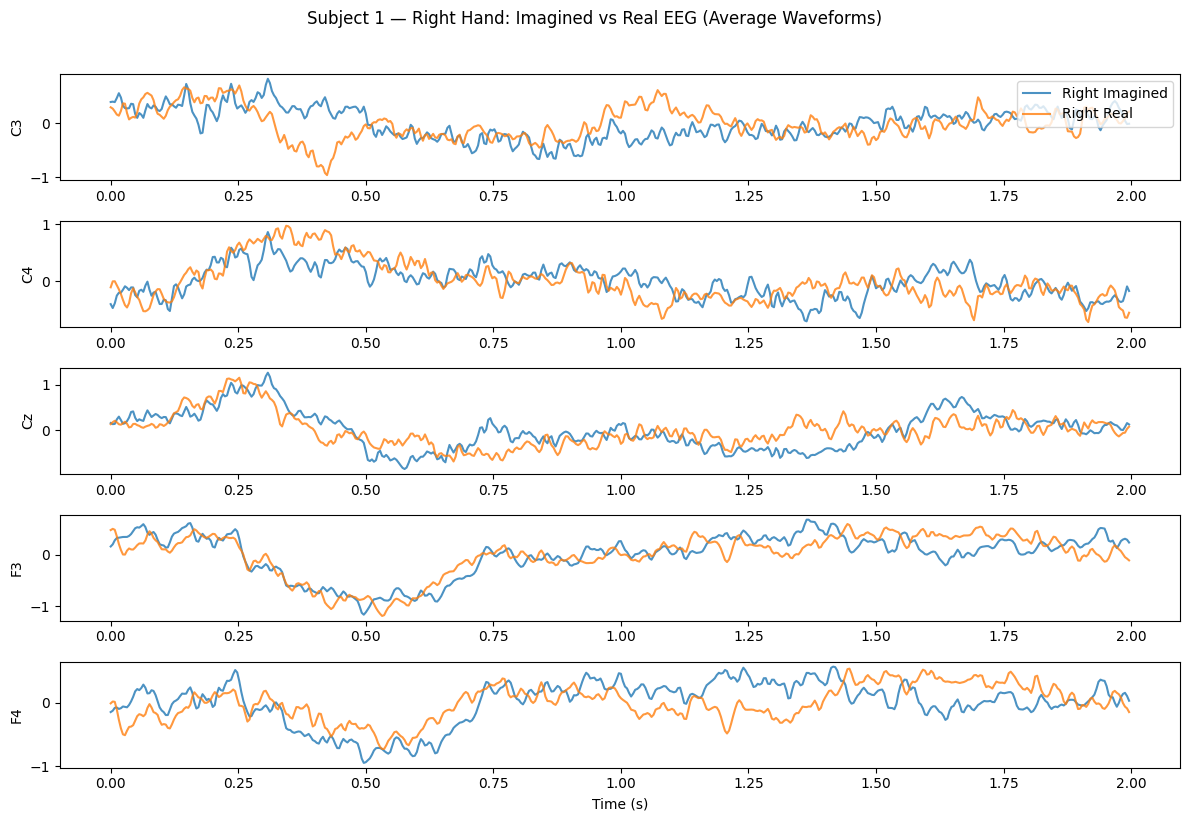

In [7]:
import matplotlib.pyplot as plt

# sample channels
channel_names = [
    "C3", "C4", "Cz", "F3", "F4"
]

neurogpt_channels = [
    "Fp1","Fp2","F7","F3","Fz","F4","F8",
    "T1","T3","C3","Cz","C4","T4","T2",
    "T5","P3","Pz","P4","T6","O1","Oz","O2"
]

channel_indices = [neurogpt_channels.index(ch) for ch in channel_names]

# Collect trials
imagined_trials = []
real_trials = []

for i in range(len(dataset)):
    sample = dataset[i]
    label = sample["labels"].item()

    # Right Imagined = 0, Right Real = 1
    if label == 0:
        imagined_trials.append(sample["inputs"])
    elif label == 1:
        real_trials.append(sample["inputs"])

# Compute average waveform per class
imagined_avg = torch.stack(imagined_trials).mean(dim=0)
real_avg = torch.stack(real_trials).mean(dim=0)

# Time axis (seconds)
sfreq = 250
time = np.arange(imagined_avg.shape[1]) / sfreq

# Plot
plt.figure(figsize=(12, 8))

for i, ch_idx in enumerate(channel_indices):
    plt.subplot(len(channel_indices), 1, i + 1)
    plt.plot(time, imagined_avg[ch_idx].numpy(), label="Right Imagined", alpha=0.8)
    plt.plot(time, real_avg[ch_idx].numpy(), label="Right Real", alpha=0.8)
    plt.ylabel(channel_names[i])
    if i == 0:
        plt.legend(loc="upper right")

plt.xlabel("Time (s)")
plt.suptitle("Subject 1 — Right Hand: Imagined vs Real EEG (Average Waveforms)", y=1.02)
plt.tight_layout()
plt.show()


In [8]:
import numpy as np

energy_by_class = defaultdict(list)

for i in range(len(dataset)):
    sample = dataset[i]
    label = sample["labels"].item()
    energy = sample["inputs"].pow(2).mean().item()
    energy_by_class[label].append(energy)

print("Mean signal energy per class:")
for k in sorted(label_map):
    print(f"{label_map[k]:<15}: {np.mean(energy_by_class[k]):.4f}")


Mean signal energy per class:
Right Imagined : 0.9163
Right Real     : 0.9236
Left Imagined  : 0.9129
Left Real      : 0.9253


## NeuroGPT Teaser

Each trial is already:
- 22-channel (NeuroGPT format)
- Normalized
- Fixed-length
- Labeled

In [9]:
batch = dataset[0]
print(batch["inputs"].shape)
print(batch["labels"].item())


torch.Size([22, 500])
1


## Loading the train, test data

In [10]:
all_subjects = list(range(1, 109))  # subject range
print("Subjects:", all_subjects)

MI_ME_RUNS = [3, 4, 7, 8, 11, 12]
print("MI_ME runs:", MI_ME_RUNS)

Subjects: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108]
MI_ME runs: [3, 4, 7, 8, 11, 12]


In [11]:
# create folds

train_folds = []
test_folds = []

for i in range(len(all_subjects) // 2):
    test_subjects = all_subjects[i*2 : i*2+2]
    train_subjects = all_subjects[:i*2] + all_subjects[i*2+2:]

    train_folds.append(train_subjects)
    test_folds.append(test_subjects)


In [ ]:
from dataloader import EEGMMIDBDataset

DATA_PATH = PROJECT_ROOT / "data" / "physionet.org" / "files" / "eegmmidb" / "1.0.0"

train_dataset = EEGMMIDBDataset(
    root_path=str(DATA_PATH),
    subjects=train_subjects,
    runs=MI_ME_RUNS,
    t_min=0.0,
    t_max=2.0,
    normalization=True
)

test_dataset = EEGMMIDBDataset(
    root_path=str(DATA_PATH),
    subjects=test_subjects,
    runs=MI_ME_RUNS,
    t_min=0.0,
    t_max=2.0,
    normalization=True
)

# Simple setup (same as your example)
validation_dataset = test_dataset


In [13]:
print("Train trials:", len(train_dataset))
print("Test trials :", len(test_dataset))

batch = train_dataset[0]
print("Input shape:", batch["inputs"].shape)   # (22, T)
print("Label:", batch["labels"].item())


Train trials: 9575
Test trials : 180
Input shape: torch.Size([22, 500])
Label: 1
